In [1]:
!pip install sacrebleu
!pip install bert-score
!pip install nltk
!pip install rouge
import nltk
nltk.download('punkt')
!pip install rouge-score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install torch
!pip install transformers
!pip install torchvision
!pip install Pillow
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install evaluate
!pip install pickle5


  Using cached pickle5-0.0.11.tar.gz (132 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickle.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-312\pickle5
      copying pickle5\__init__.py -> build\lib.win-amd64-cpython-312\pickle5
      creating build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-312\pickle5\test
      copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-312\pickle5\test
      run

In [3]:
import pandas as pd
import numpy as np
import pickle

In [4]:
# text data
df = pd.read_csv("train_df.tsv", sep="\t")

# img descriptions
with open("D_train.pkl", "rb") as f:
    image_descriptions = pickle.load(f)
print("Image Descriptions (First 5 Records):")
for key, value in list(image_descriptions.items())[:5]:
    print(f"{key}: {value}")

print()

# detected objects
with open("O_train.pkl", "rb") as f:
    detected_objects = pickle.load(f)
print("Detected Objects (First 5 Records):")
for key, value in list(detected_objects.items())[:5]:
    print(f"{key}: {value}")

Image Descriptions (First 5 Records):
931874353976938497: people sitting on the floor in a large room with a wall
880425829246922752: two twee screens of donald trump and donald trump
690915881082343424: there are two shovels that are standing in the snow
915228456757059585: arafed view of a passenger plane with a flat screen tv
494194068998468686_25639236: cars are driving down the highway on a cloudy day

Detected Objects (First 5 Records):
931874353976938497: {'classes': ['person', 'backpack', 'handbag', 'backpack', 'backpack', 'cell phone', 'person', 'person', 'person', 'cup', 'chair', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'chair', 'person', 'person', 'person', 'backpack', 'backpack', 'person', 'person', 'person', 'backpack', 'person', 'person', 'person', 'person', 'person', 'person'], 'confidence_scores': [0.0945774, 0.0975185, 0.111666, 0.117207, 0.118647, 0.120145, 0.121325, 0.217946, 0.224531, 0.226831, 0.280922, 0.29603, 0.33

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration
from torchvision.models import vit_b_16
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import evaluate

torch.manual_seed(2634)

In [6]:
import nltk
from nltk.translate.meteor_score import meteor_score

# Download NLTK data for METEOR
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
class MuSEDataset(Dataset):

    def __init__(self, text_file, image_desc_file, obj_file, image_folder, tokenizer, max_length=256, transform=None):
        ''' Initialize the MuSEDataset class. '''
        self.text_data = pd.read_csv(text_file, sep="\t")

        with open(image_desc_file, "rb") as f:
            self.image_descriptions = pickle.load(f)

        with open(obj_file, "rb") as f:
            self.detected_objects = pickle.load(f)

        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
            # mean and std dev for RGB channels
        ])


    def __len__(self):
        ''' Return the length of the dataset. '''
        return len(self.text_data)

    def __getitem__(self, idx):
        ''' Get the data for a given index.
        Here, we get:
        1. Multimodal input (txt, img desc, obj)
        2. Explanantion and target
        Tokenize them and return a dictionary of relevant data
        '''        # Get data
        row = self.text_data.iloc[idx]
        text = row["text"]
        explanation = row["explanation"] if "explanation" in row else ""
        image_name = str(row["pid"])  # Convert to string to match dictionary keys
        sarcasm_target = str(row["target_of_sarcasm"]) if pd.notna(row.get("target_of_sarcasm", "")) else ""

        # Preprocess img
        image_path = os.path.join(self.image_folder, f"{image_name}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
        except FileNotFoundError:
            # blank image if not found
            print(f"Warning: Image {image_path} not found, using blank image.")
            image = torch.zeros((3, 224, 224))

        # img desc and objects
        img_desc = self.image_descriptions.get(image_name, "No description available")
        detected_objs = self.detected_objects.get(image_name, {"classes": [], "confidence_scores": []})

        # formatting objs to string
        if isinstance(detected_objs, dict) and "classes" in detected_objs:
            obj_str = ", ".join(detected_objs["classes"])
        else:
            obj_str = "No objects detected"

        # multimodal input
        multimodal_text = f"Text: {text} Image: {img_desc} Objects: {obj_str}"

        # Tokenize inputs, explanation, target
        input_encodings = self.tokenizer(multimodal_text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        target_encodings = self.tokenizer(explanation, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        sarcasm_target_encodings = self.tokenizer(sarcasm_target, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")

        # Return the data as a dictionary

        return {
            "input_ids": input_encodings["input_ids"].squeeze(0),
            "attention_mask": input_encodings["attention_mask"].squeeze(0),
            "image": image,
            "target_ids": target_encodings["input_ids"].squeeze(0),
            "target_attention_mask": target_encodings["attention_mask"].squeeze(0),
            "sarcasm_target_ids": sarcasm_target_encodings["input_ids"].squeeze(0),
            "sarcasm_target_mask": sarcasm_target_encodings["attention_mask"].squeeze(0),
            "raw_text": text,
            "raw_explanation": explanation
        }

In [8]:
class ImageProjection(nn.Module):
    """Projects ViT image features to match BART embedding dimensions"""

    def __init__(self, input_dim=768, output_dim=768):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # print(f"Image Projection Input Shape: {x.shape}")
        return self.linear(x)

class CrossModalAttention(nn.Module):
    """Computes cross-modal attention between text and vision features"""

    def __init__(self, feature_dim=768):
        super().__init__()

        self.query_v = nn.Linear(feature_dim, feature_dim)
        self.key_v = nn.Linear(feature_dim, feature_dim)
        self.value_v = nn.Linear(feature_dim, feature_dim)

        self.query_t = nn.Linear(feature_dim, feature_dim)
        self.key_t = nn.Linear(feature_dim, feature_dim)
        self.value_t = nn.Linear(feature_dim, feature_dim)

        self.dropout = nn.Dropout(0.3)
        self.scale = feature_dim ** 0.5

    def forward(self, vision_features, text_features):
        # print(f"Cross-Modal Input Shapes: Vision={vision_features.shape}, Text={text_features.shape}")
        # self-attention for vision
        q_v = self.query_v(vision_features)
        k_v = self.key_v(vision_features)
        v_v = self.value_v(vision_features)

        attn_v = torch.matmul(q_v, k_v.transpose(-2, -1)) / self.scale
        attn_v = F.softmax(attn_v, dim=-1)
        attn_v = self.dropout(attn_v)
        Av = torch.matmul(attn_v, v_v)

        # self-attention for text
        q_t = self.query_t(text_features)
        k_t = self.key_t(text_features)
        v_t = self.value_t(text_features)

        attn_t = torch.matmul(q_t, k_t.transpose(-2, -1)) / self.scale
        attn_t = F.softmax(attn_t, dim=-1)
        attn_t = self.dropout(attn_t)
        At = torch.matmul(attn_t, v_t)

        # cross modal
        Ftv = At * vision_features
        Fvt = Av * text_features

        return Ftv, Fvt

class GatedFusion(nn.Module):
    """Gated fusion mechanism to dynamically weigh features"""

    def __init__(self, feature_dim=768):
        super().__init__()
        self.Wv = nn.Linear(feature_dim, feature_dim)
        self.Wt = nn.Linear(feature_dim, feature_dim)
        self.bv = nn.Parameter(torch.zeros(feature_dim))
        self.bt = nn.Parameter(torch.zeros(feature_dim))
        self.dropout = nn.Dropout(0.3)

    def forward(self, Ev, Et, Ftv, Fvt):
        # print(f"Gated Fusion Input Shapes: Ev={Ev.shape}, Et={Et.shape}, Ftv={Ftv.shape}, Fvt={Fvt.shape}")
        # Gate for controlling information flow
        Gv = torch.sigmoid(self.Wv(Ev) + self.bv)
        Gt = torch.sigmoid(self.Wt(Et) + self.bt)

        # Multimodal features
        F1 = (Gv * Ftv) + ((1 - Gv) * Fvt)
        F2 = (Gt * Ftv) + ((1 - Gt) * Fvt)

        # Unimodal features
        Fv = (Gv * Ev) + ((1 - Gv) * Ftv)
        Ft = (Gt * Et) + ((1 - Gt) * Fvt)

        # Apply dropout
        F1 = self.dropout(F1)
        F2 = self.dropout(F2)
        Fv = self.dropout(Fv)
        Ft = self.dropout(Ft)

        return F1, F2, Fv, Ft

class SharedFusion(nn.Module):
    """Shared fusion mechanism that combines multimodal and unimodal features"""

    def __init__(self, feature_dim=768):
        super().__init__()
        self.alpha1 = nn.Parameter(torch.ones(1))
        self.alpha2 = nn.Parameter(torch.ones(1))
        self.beta1 = nn.Parameter(torch.ones(1))
        self.beta2 = nn.Parameter(torch.ones(1))
        self.dropout = nn.Dropout(0.3)

    def forward(self, F1, F2, Fv, Ft):
        # print(f"Shared Fusion Input Shapes: F1={F1.shape}, F2={F2.shape}, Fv={Fv.shape}, Ft={Ft.shape}")
        # Linear combination
        FSF = self.alpha1 * F1 + self.alpha2 * F2 + self.beta1 * Fv + self.beta2 * Ft
        FSF = self.dropout(FSF)
        return FSF

class MuSEModel(nn.Module):
    """Complete MuSE model for sarcasm explanation generation"""

    def __init__(self, feature_dim=768, max_length=256):
        super().__init__()
        # Vision - ViT
        self.vit = vit_b_16(weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Remove classification head
        self.image_projection = ImageProjection(feature_dim, feature_dim)

        # Text - BART
        self.bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

        # Cross-modal attention
        self.cross_modal_attention = CrossModalAttention(feature_dim)

        # Fusion components
        self.gated_fusion = GatedFusion(feature_dim)
        self.shared_fusion = SharedFusion(feature_dim)

        # Dimensions and positioning
        self.feature_dim = feature_dim
        self.max_length = max_length

        # Target information projection
        self.target_projection = nn.Linear(feature_dim, feature_dim)
        # Final projection (match BART dimensions)
        self.output_projection = nn.Linear(feature_dim, feature_dim)

        print("Initializing MuSEModel...")

    def embed_text(self, input_ids, attention_mask):
        """Extract text embeddings using BART encoder"""
        encoder_outputs = self.bart.get_encoder()(  # Direct encoder access
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        return encoder_outputs.last_hidden_state

    def embed_image(self, images):
        """Extract image embeddings using ViT"""

        with torch.no_grad():
            image_features = self.vit(images)
        return self.image_projection(image_features)

    def forward(self, input_ids, attention_mask, images, target_ids=None, sarcasm_target_ids=None, sarcasm_target_mask=None):
      '''
      Et - text embeddings
      Ev - vision embeddings

      Ftv, Fvt - cross modal attention(Et,Ev)

      F1, F2, Fv, Ft - gated fusion(Ev, Et, Ftv, Fvt)
      FSF - shared fusion(F1, F2, Fv, Ft)
      Z - final output
      '''

      batch_size = input_ids.size(0)

      # Et is embeddings for (text + target)

      Et = self.embed_text(input_ids, attention_mask)
      if sarcasm_target_ids is not None and sarcasm_target_mask is not None:
          target_embed = self.embed_text(sarcasm_target_ids, sarcasm_target_mask)
          target_embed = self.target_projection(target_embed)
          Et = Et + target_embed

      # Vision embeddings
      Ev = self.embed_image(images)
      Ev = Ev.unsqueeze(1).expand(-1, self.max_length, -1)

      # Cross-modal attention
      Ftv, Fvt = self.cross_modal_attention(Ev, Et)

      # Gated fusion
      F1, F2, Fv, Ft = self.gated_fusion(Ev, Et, Ftv, Fvt)

      # Shared fusion
      FSF = self.shared_fusion(F1, F2, Fv, Ft)

      # Final projection
      Z = self.output_projection(FSF)

      if target_ids is not None:
          target_length = target_ids.size(1)
          Z = Z[:, :target_length, :]
          outputs = self.bart(
              encoder_outputs=(Z,),
              attention_mask=attention_mask,
              labels=target_ids,
              return_dict=True
          )
          return outputs
      else:
          # Create a proper encoder output object for generation
          from transformers.modeling_outputs import BaseModelOutput
          encoder_output = BaseModelOutput(last_hidden_state=Z)

          generated_ids = self.bart.generate(
              encoder_outputs=encoder_output,
              attention_mask=attention_mask,
              max_length=100,
              num_beams=5,
              early_stopping=True
          )
          return generated_ids

In [9]:
import gc
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    print(f"Total number of batches: {num_batches}")

    if num_batches == 0:
        raise ValueError("Dataloader is empty!")

    for batch_idx, batch in enumerate(dataloader):
        try:
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            target_ids = batch["target_ids"].to(device)
            sarcasm_target_ids = batch["sarcasm_target_ids"].to(device)
            sarcasm_target_mask = batch["sarcasm_target_mask"].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                images=images,
                target_ids=target_ids,
                sarcasm_target_ids=sarcasm_target_ids,
                sarcasm_target_mask=sarcasm_target_mask
            )

            # Calculate loss
            loss = outputs.loss
            if batch_idx % 20 == 0:  # Print every 10 batches
                print(f"Batch {batch_idx} loss: {loss.item():.4f}")

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            raise e

    avg_loss = total_loss / num_batches
    print(f"Epoch complete. Average loss: {avg_loss:.4f}")
    return avg_loss


def validate(model, dataloader, tokenizer, device, num_samples=5):
    model.eval()
    val_loss = 0
    generated_explanations = []
    reference_explanations = []
    sample_results = []

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            # Move inputs to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            target_ids = batch["target_ids"].to(device)
            sarcasm_target_ids = batch["sarcasm_target_ids"].to(device)
            sarcasm_target_mask = batch["sarcasm_target_mask"].to(device)

            # Forward pass with teacher forcing for loss calculation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                images=images,
                target_ids=target_ids,
                sarcasm_target_ids=sarcasm_target_ids,
                sarcasm_target_mask=sarcasm_target_mask
            )

            # Get loss
            loss = outputs.loss
            val_loss += loss.item()

            # Get explanations
            # In validate function
            generated_ids = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                images=images,
                target_ids=None,  # Set to None for generation
                sarcasm_target_ids=sarcasm_target_ids,
                sarcasm_target_mask=sarcasm_target_mask
            )

            # Decode explanations
            for i in range(input_ids.size(0)):
                gen_text = tokenizer.decode(generated_ids[i], skip_special_tokens=True)
                ref_text = tokenizer.decode(target_ids[i], skip_special_tokens=True)

                generated_explanations.append(gen_text)
                reference_explanations.append(ref_text)

                # Save sample results for display
                if len(sample_results) < num_samples:
                    original_text = batch["raw_text"][i]
                    sample_results.append({
                        "text": original_text,
                        "generated": gen_text,
                        "reference": ref_text
                    })

    # Calculate metrics
    # ROUGE
    rouge = evaluate.load("rouge")
    rouge_results = rouge.compute(
        predictions=generated_explanations,
        references=reference_explanations
    )

    # BLEU
    bleu = evaluate.load("bleu")
    bleu_results = bleu.compute(
        predictions=generated_explanations,
        references=[[r] for r in reference_explanations]  # Ensure references are in a list of lists
    )
    import nltk
    nltk.download('punkt_tab')
    from nltk.translate.meteor_score import meteor_score
    meteor_scores = [
        meteor_score(
            [nltk.word_tokenize(ref)],  # Tokenize the reference
            nltk.word_tokenize(pred)   # Tokenize the prediction
        )
        for pred, ref in zip(generated_explanations, reference_explanations)
    ]
    meteor_results = {"meteor": sum(meteor_scores) / len(meteor_scores)}

    # BERTScore
    bertscore = evaluate.load("bertscore")
    bertscore_results = bertscore.compute(
        predictions=generated_explanations,
        references=reference_explanations,
        lang="en"  # Update if using a different language
    )

    # Print results
    print("ROUGE:", rouge_results)
    print("BLEU:", bleu_results)
    print("METEOR:", meteor_results)
    print("BERTScore:", bertscore_results)

    # Calculate average loss
    avg_loss = val_loss / len(dataloader)

    return {
        "loss": avg_loss,
        "rouge": {
            "rouge1": rouge_results["rouge1"],
            "rouge2": rouge_results["rouge2"],
            "rougeL": rouge_results["rougeL"]
        },
        "bleu": {
            "bleu1": bleu_results["precisions"][0],
            "bleu2": bleu_results["precisions"][1],
            "bleu3": bleu_results["precisions"][2],
            "bleu4": bleu_results["precisions"][3]
        },
        "meteor": meteor_results["meteor"],
        "bertscore": bertscore_results["f1"][0],
        "samples": sample_results[:5]
    }

def train_model(model, train_loader, val_loader, tokenizer, device,
                 epochs, lr, checkpoint_dir="checkpoints"):
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    bleu_scores = {"bleu1": [], "bleu2": [], "bleu3": [], "bleu4": []}
    meteor_scores = []
    bertscore_scores = []

    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # train - 1 epoch
        print(f"Training on epoch {epoch + 1}...")
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        print(f"Training Loss: {train_loss:.4f}")

        # validate
        val_results = validate(model, val_loader, tokenizer, device)
        val_losses.append(val_results["loss"])

        # Store all metrics
        for key in rouge_scores.keys():
            rouge_scores[key].append(val_results["rouge"][key])
        for key in bleu_scores.keys():
            bleu_scores[key].append(val_results["bleu"][key])
        meteor_scores.append(val_results["meteor"])
        bertscore_scores.append(val_results["bertscore"])

        # Print metrics
        print(f"Validation Loss: {val_results['loss']:.4f}")
        print("ROUGE Scores:")
        print(f"  ROUGE-1: {val_results['rouge']['rouge1']:.4f}")
        print(f"  ROUGE-2: {val_results['rouge']['rouge2']:.4f}")
        print(f"  ROUGE-L: {val_results['rouge']['rougeL']:.4f}")
        print("BLEU Scores:")
        print(f"  BLEU-1: {val_results['bleu']['bleu1']:.4f}")
        print(f"  BLEU-2: {val_results['bleu']['bleu2']:.4f}")
        print(f"  BLEU-3: {val_results['bleu']['bleu3']:.4f}")
        print(f"  BLEU-4: {val_results['bleu']['bleu4']:.4f}")
        print(f"METEOR: {val_results['meteor']:.4f}")
        print(f"BERTScore: {val_results['bertscore']:.4f}")

        # sample results
        print("\nSample Results:")
        for i, sample in enumerate(val_results["samples"]):
            print(f"Example {i+1}:")
            print(f"Text: {sample['text']}")
            print(f"Generated: {sample['generated']}")
            print(f"Reference: {sample['reference']}")
            print()

        # save checkpt
        checkpoint_path = os.path.join(checkpoint_dir, f"muse_model_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_results["loss"],
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

        # Clear GPU memory
        torch.cuda.empty_cache()
        gc.collect()

    # Plot training progress
    plt.figure(figsize=(18, 12))

    # Plot 1: Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot 2: ROUGE scores
    plt.subplot(2, 3, 2)
    plt.plot(rouge_scores['rouge1'], label='ROUGE-1')
    plt.plot(rouge_scores['rouge2'], label='ROUGE-2')
    plt.plot(rouge_scores['rougeL'], label='ROUGE-L')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('ROUGE Scores')

    # Plot 3: BLEU scores
    plt.subplot(2, 3, 3)
    plt.plot(bleu_scores['bleu1'], label='BLEU-1')
    plt.plot(bleu_scores['bleu2'], label='BLEU-2')
    plt.plot(bleu_scores['bleu3'], label='BLEU-3')
    plt.plot(bleu_scores['bleu4'], label='BLEU-4')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('BLEU Scores')

    # Plot 4: METEOR score
    plt.subplot(2, 3, 4)
    plt.plot(meteor_scores, label='METEOR')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('METEOR Score')

    # Plot 5: BERTScore
    plt.subplot(2, 3, 5)
    plt.plot(bertscore_scores, label='BERTScore')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('BERTScore')

    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'training_progress.png'))
    plt.show()

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'rouge_scores': rouge_scores,
        'bleu_scores': bleu_scores,
        'meteor_scores': meteor_scores,
        'bertscore_scores': bertscore_scores
    }

In [ ]:
import gc

def train_and_validate():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # BART tokenizer
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


    # Full training dataset
    train_dataset = MuSEDataset(
        text_file="train_df.tsv",
        image_desc_file="D_train.pkl",
        obj_file="O_train.pkl",
        image_folder="images",
        tokenizer=tokenizer
    )

    val_dataset = MuSEDataset(
        text_file="val_df.tsv",
        image_desc_file="D_val.pkl",
        obj_file="O_val.pkl",
        image_folder="images",
        tokenizer=tokenizer
    )

    # dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=0
    )

    print(f"Train dataset size: {len(train_loader.dataset)}")
    print(f"Number of batches: {len(train_loader)}")

    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0
    )

    print(len(val_loader.dataset))

        # model
    model = MuSEModel().to(device)

    # train
    train_results = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        tokenizer=tokenizer,
        device=device,
        epochs=8,
        lr=1e-4,
        checkpoint_dir="checkpoints"
    )

    print("Training complete.")

    print("Saving final model...")

    # Save final model
    model_path = os.path.join("checkpoints", "final_model.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    return model, train_results

def test_model():
    model_path="checkpoints/final_model.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load tokenizer
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

    # Load model
    model = MuSEModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load test data
    test_dataset = MuSEDataset(
        text_file="test_df.tsv",
        image_desc_file="D_test.pkl",
        obj_file="O_test.pkl",
        image_folder="images",
        tokenizer=tokenizer
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0
    )
    
    test_results = validate(model, test_loader, tokenizer, device)
    
    print("\nTest Results:")
    # Print metrics
    print(f"Validation Loss: {test_results['loss']:.4f}")
    print("ROUGE Scores:")
    print(f"  ROUGE-1: {test_results['rouge']['rouge1']:.4f}")
    print(f"  ROUGE-2: {test_results['rouge']['rouge2']:.4f}")
    print(f"  ROUGE-L: {test_results['rouge']['rougeL']:.4f}")
    print("BLEU Scores:")
    print(f"  BLEU-1: {test_results['bleu']['bleu1']:.4f}")
    print(f"  BLEU-2: {test_results['bleu']['bleu2']:.4f}")
    print(f"  BLEU-3: {test_results['bleu']['bleu3']:.4f}")
    print(f"  BLEU-4: {test_results['bleu']['bleu4']:.4f}")
    print(f"METEOR: {test_results['meteor']:.4f}")
    print(f"BERTScore: {test_results['bertscore']:.4f}")
    
        # sample results
    print("\nSample Results:")
    for i, sample in enumerate(test_results["samples"]):
        print(f"Example {i+1}:")
        print(f"Text: {sample['text']}")
        print(f"Generated: {sample['generated']}")
        print(f"Reference: {sample['reference']}")
        print()
    return test_results

In [11]:
torch.cuda.empty_cache()
gc.collect()

60

Using device: cuda
Train dataset size: 2983
Number of batches: 187
175
Initializing MuSEModel...
Epoch 1/8
Training on epoch 1...
Total number of batches: 187
Batch 0 loss: 16.7923
Batch 20 loss: 4.1035
Batch 40 loss: 0.5931
Batch 60 loss: 0.4071
Batch 80 loss: 0.3629
Batch 100 loss: 0.3079
Batch 120 loss: 0.2778
Batch 140 loss: 0.2853
Batch 160 loss: 0.2631
Batch 180 loss: 0.2763
Epoch complete. Average loss: 1.4646
Training Loss: 1.4646


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.16201204625164672, 'rouge2': 0.07343301444083433, 'rougeL': 0.15534271059030474, 'rougeLsum': 0.1541327471084739}
BLEU: {'bleu': 0.07464332545673948, 'precisions': [0.2672413793103448, 0.10193413486670151, 0.0661680092059839, 0.04286628278950736], 'brevity_penalty': 0.7961486624856023, 'length_ratio': 0.8143525741029641, 'translation_length': 2088, 'reference_length': 2564}
METEOR: {'meteor': 0.16944226176780763}
BERTScore: {'precision': [0.9440679550170898, 0.8513818979263306, 0.8469984531402588, 0.8313425779342651, 0.8666226267814636, 0.940030038356781, 0.8900492191314697, 0.835945725440979, 0.832985520362854, 0.8385353684425354, 0.9577702879905701, 0.8380882740020752, 0.8783255815505981, 0.8533161878585815, 0.8397219777107239, 0.8837586641311646, 0.8546304702758789, 0.8505173921585083, 0.8590890765190125, 0.8456614017486572, 0.8842334747314453, 0.8556027412414551, 0.8270558714866638, 0.865159273147583, 0.9389674663543701, 0.906376838684082, 0.8488806486129761, 0.

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.16868411400812822, 'rouge2': 0.06681455283511889, 'rougeL': 0.1571328209122908, 'rougeLsum': 0.1561365681017463}
BLEU: {'bleu': 0.0755723908002492, 'precisions': [0.2395954881369117, 0.082220367278798, 0.05132823052678973, 0.03225806451612903], 'brevity_penalty': 1.0, 'length_ratio': 1.0027301092043681, 'translation_length': 2571, 'reference_length': 2564}
METEOR: {'meteor': 0.17877640040131626}
BERTScore: {'precision': [0.9513600468635559, 0.8596116304397583, 0.8534848690032959, 0.848207414150238, 0.8735276460647583, 0.9409036636352539, 0.8962401151657104, 0.835945725440979, 0.8542986512184143, 0.8552268743515015, 0.9576880931854248, 0.8512038588523865, 0.8861514329910278, 0.8603222370147705, 0.8560608625411987, 0.8856401443481445, 0.8642551898956299, 0.8568375110626221, 0.8708984851837158, 0.8580330610275269, 0.8872683048248291, 0.8610890507698059, 0.845515787601471, 0.868645429611206, 0.9389674663543701, 0.9007306098937988, 0.8542320728302002, 0.8360226154327393,

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.16950588871125466, 'rouge2': 0.0660675685492857, 'rougeL': 0.15547661178606648, 'rougeLsum': 0.1542226865667055}
BLEU: {'bleu': 0.0695575628015806, 'precisions': [0.2270135424091233, 0.07677689091600153, 0.046416938110749185, 0.02893467777290662], 'brevity_penalty': 1.0, 'length_ratio': 1.094383775351014, 'translation_length': 2806, 'reference_length': 2564}
METEOR: {'meteor': 0.1832905448942709}
BERTScore: {'precision': [0.9513600468635559, 0.8540902137756348, 0.8561964631080627, 0.8507480621337891, 0.857818603515625, 0.9024601578712463, 0.8962401151657104, 0.8359458446502686, 0.8542986512184143, 0.8493874669075012, 0.9544920921325684, 0.8421363830566406, 0.8809465169906616, 0.8479083180427551, 0.8504116535186768, 0.8944265842437744, 0.8642551898956299, 0.8568375110626221, 0.8395115733146667, 0.8580330610275269, 0.8842335939407349, 0.8610890507698059, 0.8455158472061157, 0.868645429611206, 0.9389674663543701, 0.8954179286956787, 0.8429861068725586, 0.84095281362533

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.1667077804154774, 'rouge2': 0.06806010156457756, 'rougeL': 0.1583925737923091, 'rougeLsum': 0.157408007979658}
BLEU: {'bleu': 0.07517912226862199, 'precisions': [0.24322136786726023, 0.08449477351916376, 0.053276756247053275, 0.03391572456320658], 'brevity_penalty': 0.9630628693935472, 'length_ratio': 0.9637285491419657, 'translation_length': 2471, 'reference_length': 2564}
METEOR: {'meteor': 0.17527566209598264}
BERTScore: {'precision': [0.9513600468635559, 0.8540902137756348, 0.8340518474578857, 0.8322427272796631, 0.8743565082550049, 0.9409036636352539, 0.8962401151657104, 0.8326613903045654, 0.8448559045791626, 0.8451526761054993, 0.9496039748191833, 0.8508263826370239, 0.8743789196014404, 0.8522453308105469, 0.8531233668327332, 0.8868118524551392, 0.8624109029769897, 0.8465234637260437, 0.8708984851837158, 0.832534909248352, 0.8786455988883972, 0.8610890507698059, 0.8364311456680298, 0.866486132144928, 0.9352768659591675, 0.8932209610939026, 0.8410341739654541,

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.16477451162595375, 'rouge2': 0.06860829625439939, 'rougeL': 0.1561407971701638, 'rougeLsum': 0.15566434559858427}
BLEU: {'bleu': 0.07601323641031922, 'precisions': [0.23552123552123552, 0.08364389233954451, 0.05223214285714286, 0.0324455205811138], 'brevity_penalty': 1.0, 'length_ratio': 1.0101404056162246, 'translation_length': 2590, 'reference_length': 2564}
METEOR: {'meteor': 0.17661437238716018}
BERTScore: {'precision': [0.9513600468635559, 0.8560073375701904, 0.8428113460540771, 0.849817156791687, 0.8612067699432373, 0.9409036636352539, 0.8962401151657104, 0.8347684741020203, 0.8473809361457825, 0.8336238861083984, 0.9570331573486328, 0.847313642501831, 0.8797204494476318, 0.8533161878585815, 0.856060802936554, 0.8773325681686401, 0.8642551898956299, 0.8507932424545288, 0.8425724506378174, 0.8348993062973022, 0.8851324319839478, 0.8670729398727417, 0.8383642435073853, 0.868645429611206, 0.9404982924461365, 0.8994682431221008, 0.8542320728302002, 0.8255531787872

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.1772697149515634, 'rouge2': 0.06979044500582407, 'rougeL': 0.16785122301113897, 'rougeLsum': 0.16792472713203682}
BLEU: {'bleu': 0.07387195561720437, 'precisions': [0.2614980289093298, 0.0896584440227704, 0.0553543714433523, 0.03754266211604096], 'brevity_penalty': 0.8841896865228275, 'length_ratio': 0.890405616224649, 'translation_length': 2283, 'reference_length': 2564}
METEOR: {'meteor': 0.179827002190531}
BERTScore: {'precision': [0.9513600468635559, 0.8423999547958374, 0.8589963316917419, 0.8327555656433105, 0.9101406335830688, 0.9443020820617676, 0.8851436376571655, 0.8326613306999207, 0.8473809361457825, 0.8451526761054993, 0.9497840404510498, 0.8344107270240784, 0.8797204494476318, 0.8533161878585815, 0.8446778655052185, 0.8814042210578918, 0.9036803245544434, 0.8591083288192749, 0.8644254803657532, 0.8846536874771118, 0.8790080547332764, 0.8546992540359497, 0.8364311456680298, 0.8866775631904602, 0.935072660446167, 0.9051178693771362, 0.8417148590087891, 0.

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.16146140393142744, 'rouge2': 0.06093697298621909, 'rougeL': 0.14836768806696737, 'rougeLsum': 0.14764924621148062}
BLEU: {'bleu': 0.06441243427872886, 'precisions': [0.2103494623655914, 0.06854694751874331, 0.043031226199543034, 0.0277437780497756], 'brevity_penalty': 1.0, 'length_ratio': 1.1606864274570983, 'translation_length': 2976, 'reference_length': 2564}
METEOR: {'meteor': 0.17538048034411433}
BERTScore: {'precision': [0.940047025680542, 0.8607839345932007, 0.869526743888855, 0.8712807893753052, 0.8612018823623657, 0.9140499830245972, 0.8897777795791626, 0.847653865814209, 0.8405972719192505, 0.838382363319397, 0.9497840404510498, 0.8454596996307373, 0.8726037740707397, 0.8343152403831482, 0.835991621017456, 0.8814041614532471, 0.8640055060386658, 0.8326655626296997, 0.907158613204956, 0.8846535682678223, 0.8689555525779724, 0.8782097697257996, 0.8800083994865417, 0.8483641147613525, 0.935072660446167, 0.8638608455657959, 0.827821671962738, 0.8394898772239685

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Akshat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE: {'rouge1': 0.1639378689930037, 'rouge2': 0.06351713612952724, 'rougeL': 0.15293891111841096, 'rougeLsum': 0.15255755063840004}
BLEU: {'bleu': 0.06926000945029454, 'precisions': [0.22345726331927943, 0.07354149548069022, 0.045595396193005754, 0.030710172744721688], 'brevity_penalty': 1.0, 'length_ratio': 1.0175507020280812, 'translation_length': 2609, 'reference_length': 2564}
METEOR: {'meteor': 0.1744139607043233}
BERTScore: {'precision': [0.9473553895950317, 0.8770200610160828, 0.8585060834884644, 0.8720667362213135, 0.9026280641555786, 0.9109448194503784, 0.8899030685424805, 0.8291438817977905, 0.838342547416687, 0.8466127514839172, 0.9535079002380371, 0.8289353251457214, 0.8797204494476318, 0.8383513689041138, 0.8452186584472656, 0.8759489059448242, 0.848913848400116, 0.857938826084137, 0.9238541126251221, 0.8559608459472656, 0.8790079951286316, 0.8643266558647156, 0.83836430311203, 0.8533307313919067, 0.9368860721588135, 0.8892093896865845, 0.8488806486129761, 0.840989232063

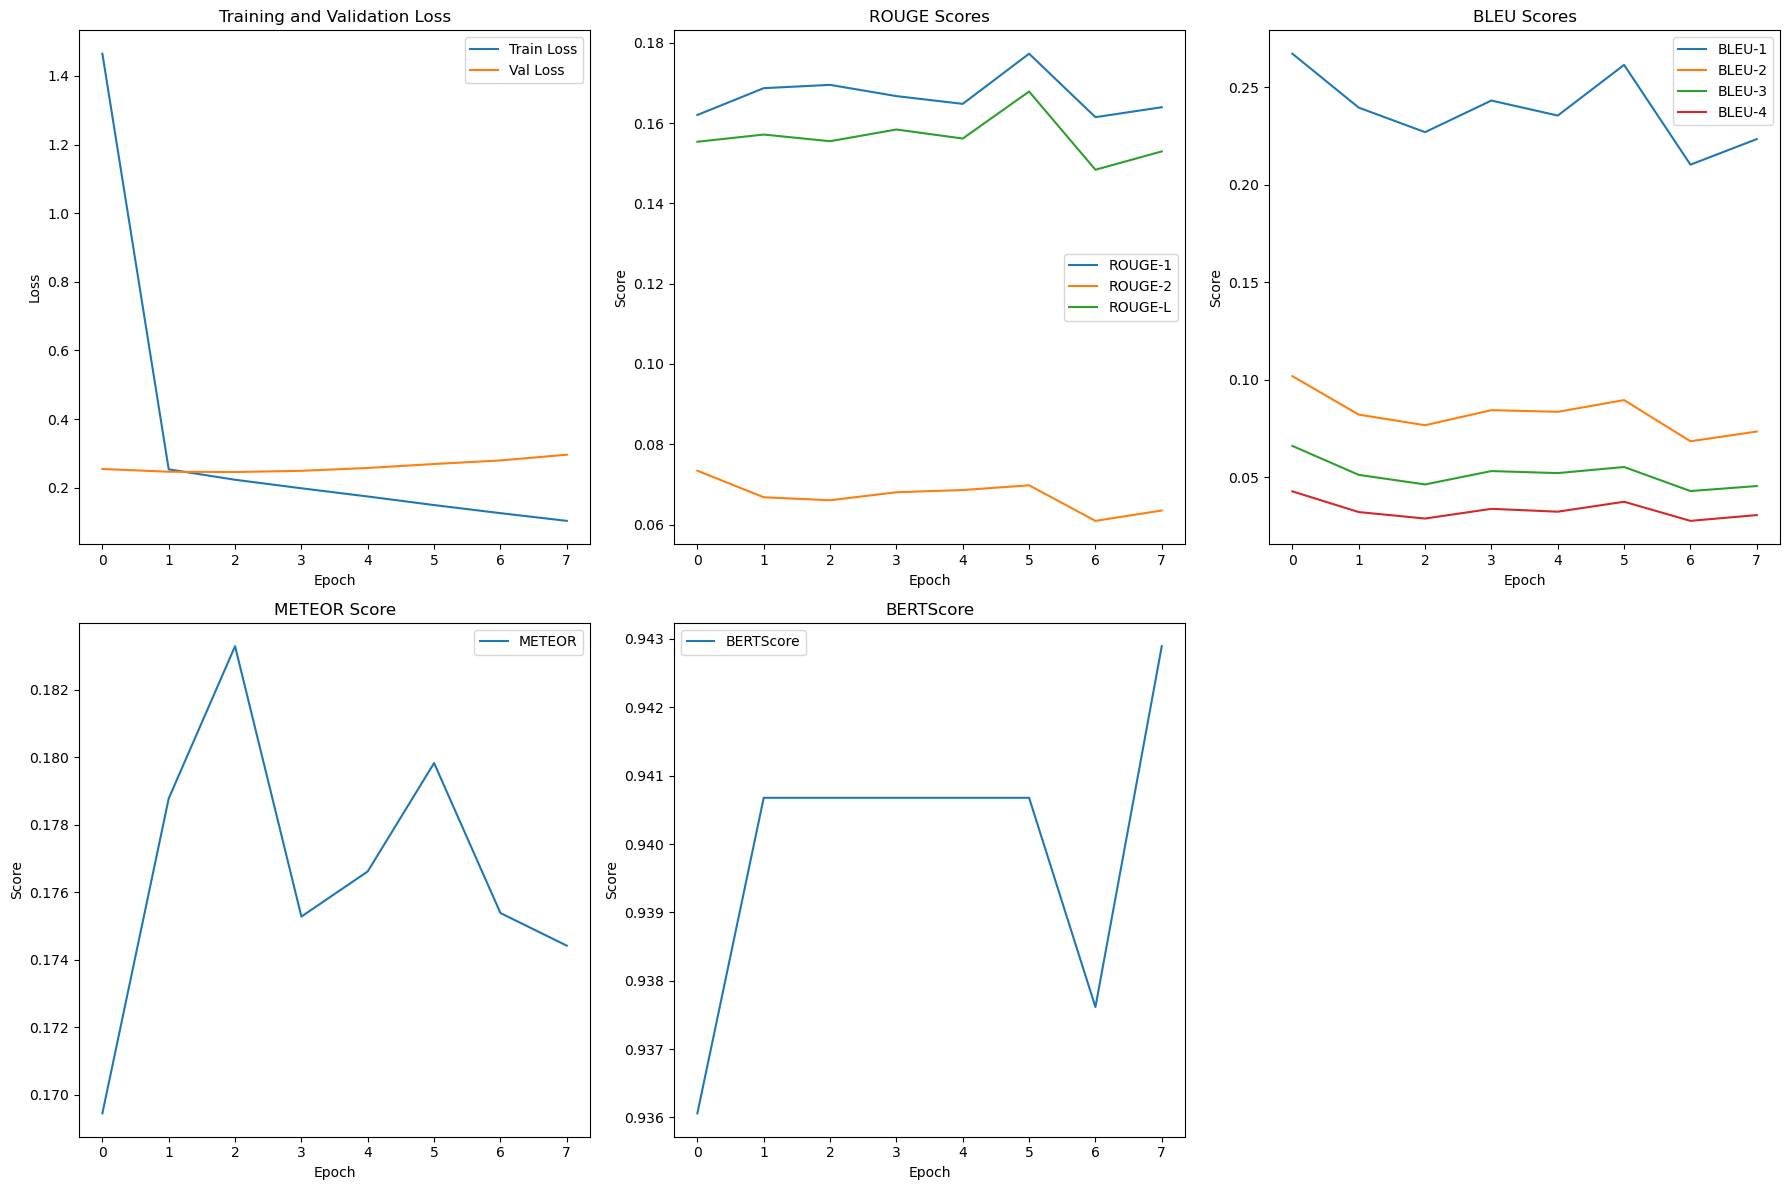

Training complete.
Saving final model...
Model saved to checkpoints\final_model.pt


In [12]:
model, train_results = train_and_validate()

In [13]:
test_results = test_model()

Using device: cuda
Initializing MuSEModel...


C:\Users\Akshat\AppData\Local\Temp\ipykernel_11536\1545115668.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FileNotFoundError: [Errno 2] No such file or directory: 'test_df.tsv'